# Corona in Hamburg

In [1]:
import datetime
import json
import os
import re
import urllib.parse

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
BOROUGHS = {
    "Altona": 275265,
    "Bergedorf": 130260,
    "Eimsbüttel": 267053,
    "Hamburg Mitte": 301546,
    "Hamburg Nord": 314595,
    "Harburg": 169426,
    "Wandsbek": 441015,
    "Hamburg": 1899160,
}

In [3]:
RESTRICTIONS = {
    datetime.date(2020, 2, 29): ("", "w"),
    datetime.date(2020, 3, 16): ("schools closed", "y"),
    datetime.date(2020, 3, 23): ("lockdown", "r"),
    datetime.date(2020, 4, 20): ("", "y"),
    datetime.date(2020, 4, 27): ("masks required", "g"),
    datetime.date(2020, 10, 12): ("masks required in more areas", "b"),
    datetime.date(2020, 10, 26): ("contact restrictions", "y"),
    datetime.date(2020, 11, 2): ("lockdown \"light\"", "m"),
    datetime.date(2020, 12, 16): ("lockdown", "r"),
    datetime.date(2021, 4, 2): ("curfew", "r"),
    datetime.date(2021, 5, 22): ("less restrictions", "y"),
    datetime.date(2021, 7, 2): ("most restrictions lifted", "g"),
    datetime.date(2021, 11, 24): ("restrictions for non-vaccinated", "y"),
}

In [4]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    soup = bs4.BeautifulSoup(r.text)
    historic_case_data_header = soup.find("h2", text="Inzidenz zum Download")
    if historic_case_data_header:
        df = pd.read_excel(
            urllib.parse.urljoin(
                CORONA_DATA_URL,
                historic_case_data_header.parent.find_next("div").a["href"]
            ),
            index_col=1,
            skiprows=[0],
            parse_dates=True
        )
        daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
        df = df.drop(
            set(df.columns) - {"Datum", "Gesamthaft gemeldete SARS-CoV-2 Infektionen"},
            axis="columns"
        ).rename(columns={
            "Datum": "date",
            "Gesamthaft gemeldete SARS-CoV-2 Infektionen": "cases"
        })

        try:
            date = pd.DateOffset(days=-1).apply(df.index[0])
            df.loc[date] = daily_cases.cumsum().loc[date]
            df = df.dropna().sort_index().diff().dropna().astype(int)

            daily_cases.update(df)
            daily_cases.astype(int).to_csv("corona-hamburg-daily.csv")
        
        except Exception as e:
            pass

    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if not header:
        header = soup.find("h2", text="Neue Fälle: Sieben Tage Inzidenz")

    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Bei der Inzidenz"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            with open("corona-hamburg-daily.csv", "r+") as f:
                lines = [line.strip() for line in f]
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find(lambda el: el.name == "h3" and "Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken" in el.text)
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip().replace(".", ""))

        with open("corona-hamburg.csv", "r+") as f:
            lines = [line.strip() for line in f]
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2 and not any(timestamp in l for l in lines):
                f.write(f"{total_cases_line}\n")

In [5]:
r = requests.get("https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_Hamburg")
if r.ok:
    soup = bs4.BeautifulSoup(r.text)
    data = json.loads(re.findall(r"RLCONF=(.*?);", soup.script.string, re.DOTALL)[0].replace("!0", "true").replace("!1", "false"))
    graph_id = soup.find_all(attrs={"class": "mw-graph"})[3]["data-graph-id"]
    df = pd.DataFrame([[datetime.datetime.strptime(e["x"], "%Y/%m/%d").date(), e["y"]] for e in data["wgGraphSpecs"][graph_id]["data"][0]["values"]], columns=["date", "deaths"]).set_index("date").astype(int)
    df.to_csv("corona-hamburg-deaths.csv")

In [6]:
daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()

In [7]:
total_cases = pd.read_csv("corona-hamburg.csv", index_col=0, parse_dates=True)
new_cases = total_cases.diff().dropna().astype(int)

In [8]:
total_deaths = pd.read_csv("corona-hamburg-deaths.csv", index_col=0, parse_dates=True)

In [9]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Total Cases

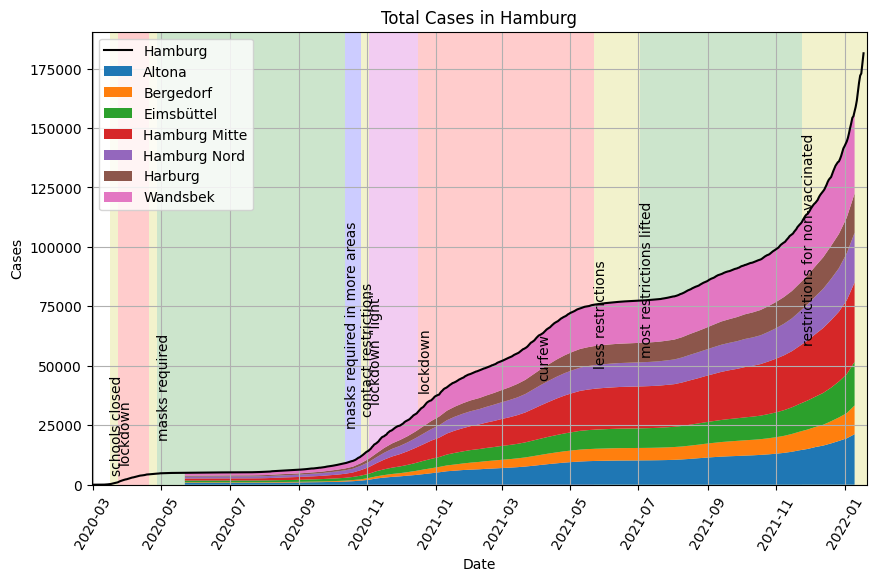

In [10]:
plt.figure()
plt.title("Total Cases in Hamburg")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(total_cases.index, *total_cases.values.T, labels=total_cases.columns)
plt.plot(daily_cases.index, daily_cases.cumsum().values, "black", label="Hamburg")
y = 0
dy = 5000 # (daily_cases.cumsum().values.max() - 5000) / (len(RESTRICTIONS) - 1)
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
    plt.annotate(text, (date, y), rotation=90)
    y += dy
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

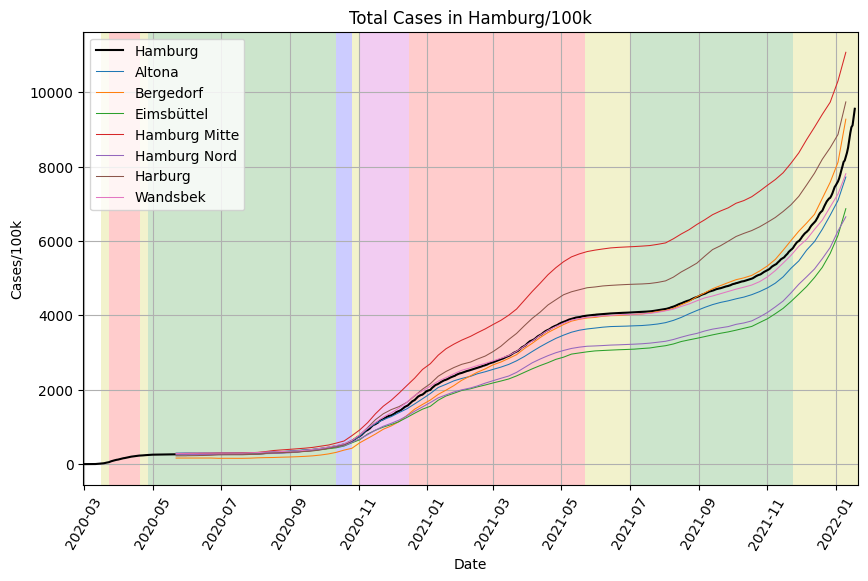

In [11]:
plt.figure()
plt.title("Total Cases in Hamburg/100k")
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.plot(daily_cases.index, daily_cases.cumsum().values / BOROUGHS["Hamburg"] * 1e5, "black", label="Hamburg")
for borough in new_cases.columns:
    plt.plot(total_cases.index, total_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

In [12]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2021-11-08,13389,7168,10797,23068,13296,11234,22943,101895
2021-11-15,13859,7490,11183,23620,13793,11507,23831,105283
2021-11-22,14492,7829,11674,24390,14480,11812,24746,109423
2021-11-29,15038,8157,12207,25235,15213,12197,25826,113873
2021-12-06,15835,8442,12751,26310,15847,12716,26647,118548
2021-12-13,16464,8748,13394,27313,16502,13250,27824,123495
2021-12-20,17380,9307,14129,28358,17376,13889,28931,129370
2021-12-27,18415,9867,15120,29336,18319,14410,30490,135957
2022-01-03,19513,10572,16427,31068,19723,15016,32023,144342


In [13]:
daily_cases.cumsum().tail(8).T

date,2022-01-11,2022-01-12,2022-01-13,2022-01-14,2022-01-15,2022-01-16,2022-01-17,2022-01-18
cases,158954,161544,165308,169149,172064,172958,177013,181438


## New Cases

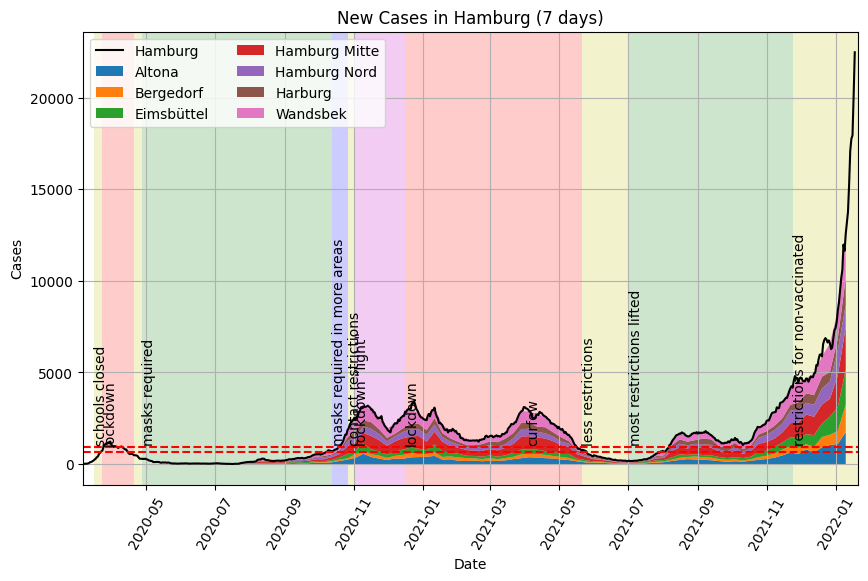

In [14]:
plt.figure()
plt.title("New Cases in Hamburg (7 days)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(new_cases.index, *new_cases.values.T, labels=new_cases.columns)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
plt.axhline(y=950, c="r", ls="dashed")
plt.axhline(y=665, c="r", ls="dashed")
xmax = daily_cases_rolling7.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
    plt.annotate(text, (date, 1200), rotation=90)
plt.legend(loc="upper left", ncol=2)
plt.xlim(xmin=daily_cases_rolling7.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

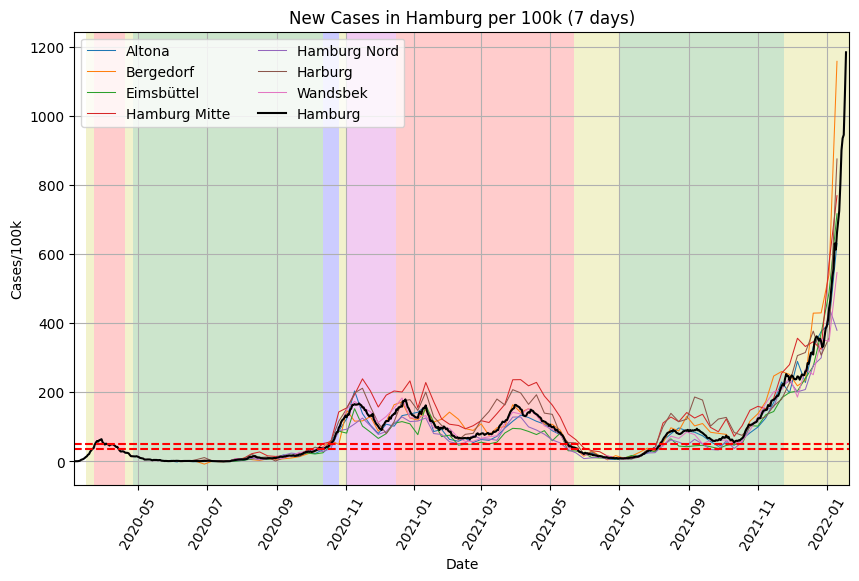

In [15]:
plt.figure()
for borough in new_cases.columns:
    plt.plot(new_cases.index, new_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values / BOROUGHS["Hamburg"] * 1e5, "k-", label="Hamburg")
plt.axhline(y=50, c="r", ls="--")
plt.axhline(y=35, c="r", ls="--")
xmax = daily_cases_rolling7.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.title("New Cases in Hamburg per 100k (7 days)")
plt.legend(loc="upper left", ncol=2)
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases_rolling7.index[0], xmax=xmax)
plt.grid()
plt.show()

In [16]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2021-11-08,347,226,361,461,470,219,743,2827
2021-11-15,470,322,386,552,497,273,888,3388
2021-11-22,633,339,491,770,687,305,915,4140
2021-11-29,546,328,533,845,733,385,1080,4450
2021-12-06,797,285,544,1075,634,519,821,4675
2021-12-13,629,306,643,1003,655,534,1177,4947
2021-12-20,916,559,735,1045,874,639,1107,5875
2021-12-27,1035,560,991,978,943,521,1559,6587
2022-01-03,1098,705,1307,1732,1404,606,1533,8385


In [17]:
(new_cases / pd.DataFrame(BOROUGHS, index=new_cases.index) * 1e5).round(2).tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2021-11-08,126.06,173.50,135.18,152.88,149.40,129.26,168.47,148.86
2021-11-15,170.74,247.20,144.54,183.06,157.98,161.13,201.35,178.39
2021-11-22,229.96,260.25,183.86,255.35,218.38,180.02,207.48,217.99
2021-11-29,198.35,251.80,199.59,280.22,233.00,227.24,244.89,234.31
2021-12-06,289.54,218.79,203.70,356.50,201.53,306.33,186.16,246.16
2021-12-13,228.51,234.91,240.78,332.62,208.20,315.18,266.88,260.48
2021-12-20,332.77,429.14,275.23,346.55,277.82,377.16,251.01,309.35
2021-12-27,376.00,429.91,371.09,324.33,299.75,307.51,353.50,346.84
2022-01-03,398.89,541.23,489.42,574.37,446.29,357.68,347.61,441.51


In [18]:
daily_cases_rolling7.tail(8).T

date,2022-01-11,2022-01-12,2022-01-13,2022-01-14,2022-01-15,2022-01-16,2022-01-17,2022-01-18
cases,13144.0,13769.0,15269.0,17099.0,17758.0,17950.0,20107.0,22484.0


In [19]:
df = (daily_cases_rolling7 / BOROUGHS["Hamburg"] * 1e5).round(2)
df["weekday"] = df.index.day_name()
df["week"] = df.index.isocalendar().week
df["year"] = [i.year - 1 if i.week in [52, 53] and i.month == 1 else i.year for i in df.index]
df.pivot(index=("year", "week"), columns=["weekday"])["cases"][WEEKDAYS].loc[(2021, 1):].tail(10)

weekday     Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
year week                                                                 
2021 46     178.39   181.40     185.98    190.08  189.98    199.09  209.78
     47     217.99   223.78     219.52    238.53  252.85    247.64  247.21
     48     234.31   243.74     249.00    245.63  239.16    237.47  238.21
     49     246.16   244.90     236.63    244.00  251.90    249.69  249.85
     50     260.48   262.85     284.49    282.91  301.50    314.24  315.24
     51     309.35   344.99     356.42    361.95  357.63    349.26  355.42
     52     346.84   330.67     334.25    361.42  384.43    390.96  408.08
2022 1      441.51   464.63     500.75    534.55  558.04    630.86  613.32
     2      661.56   692.10     725.00    803.99  900.35    935.04  945.15
     3     1058.73  1183.89        NaN       NaN     NaN       NaN     NaN

## Daily Cases

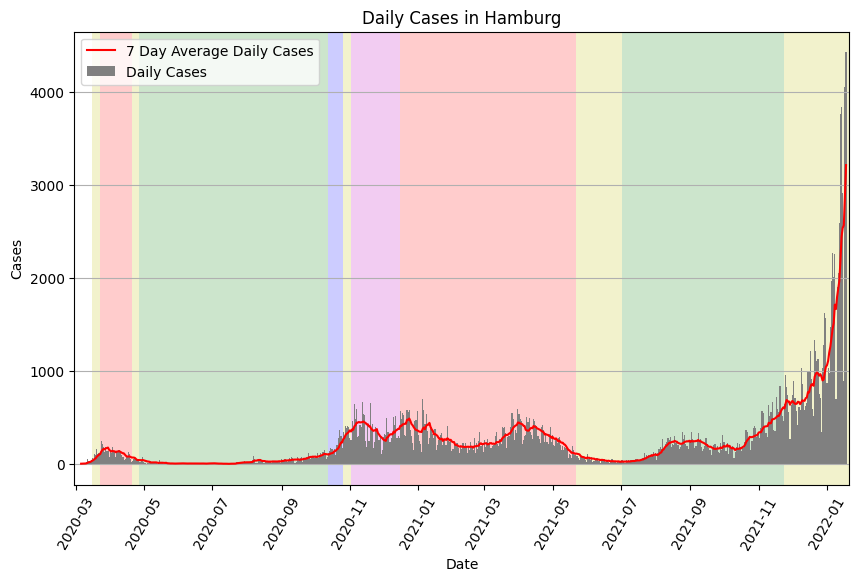

In [20]:
plt.figure()
plt.bar(daily_cases.index, daily_cases.values.T[0], width=1, color="grey", label="Daily Cases")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7 / 7, "red", label="7 Day Average Daily Cases")
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.title("Daily Cases in Hamburg")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.grid(axis="y")
plt.show()

In [21]:
df = daily_cases.copy()
df["weekday"] = df.index.day_name()
df["week"] = df.index.isocalendar().week
df["year"] = [i.year - 1 if i.week in [52, 53] and i.month == 1 else i.year for i in df.index]
df = df.pivot(index=("year", "week"), columns=["weekday"])["cases"][WEEKDAYS]
df["mean"] = df.mean(axis=1).round(2)
df.loc[(2021, 1):].tail(10)

weekday    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
year week                                                                   
2021 46     358.0    349.0      721.0     594.0   558.0     839.0   565.0   
     47     514.0    459.0      640.0     955.0   830.0     740.0   557.0   
     48     269.0    638.0      740.0     891.0   707.0     708.0   571.0   
     49     420.0    614.0      583.0    1031.0   857.0     666.0   574.0   
     50     622.0    659.0      994.0    1001.0  1210.0     908.0   593.0   
     51     510.0   1336.0     1211.0    1106.0  1128.0     749.0   710.0   
     52     347.0   1029.0     1279.0    1622.0  1565.0     873.0  1035.0   
2022 1      982.0   1468.0     1965.0    2264.0  2011.0    2256.0   702.0   
     2     1898.0   2048.0     2590.0    3764.0  3841.0    2915.0   894.0   
     3     4055.0   4425.0        NaN       NaN     NaN       NaN     NaN   

weekday       mean  
year week           
2021 46     569.14  
     47     670.71  
     48     646.29  
     49     677.86  
     50     855.29  
     51     964.29  
     52    1107.14  
2022 1     1664.00  
     2     2564.29  
     3     4240.00

In [22]:
(daily_cases_rolling7 / 7).tail(8).T.round(2)

date,2022-01-11,2022-01-12,2022-01-13,2022-01-14,2022-01-15,2022-01-16,2022-01-17,2022-01-18
cases,1877.71,1967.0,2181.29,2442.71,2536.86,2564.29,2872.43,3212.0


## Deaths

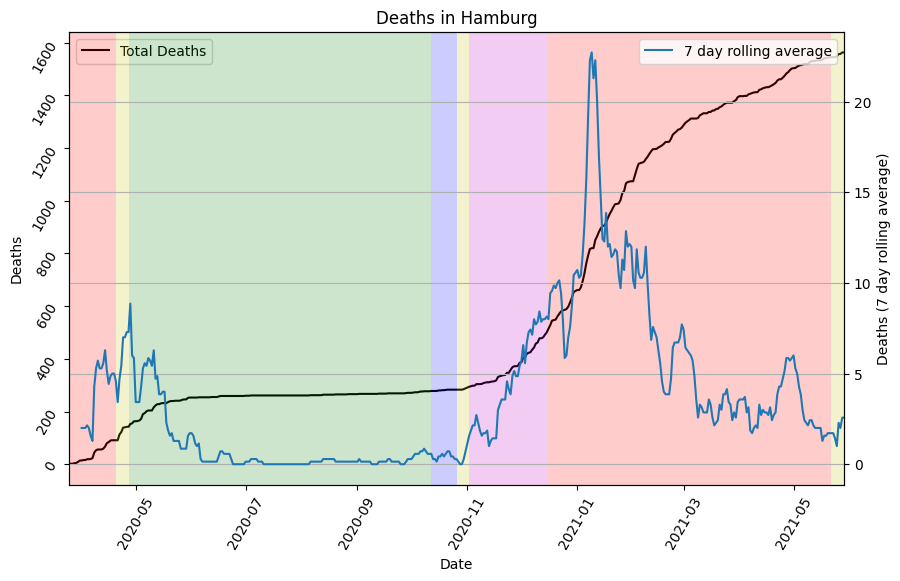

In [23]:
rolling_deaths = total_deaths.diff().rolling(7).mean()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(total_deaths.index, total_deaths, "black", label="Total Deaths")
ax2.plot(rolling_deaths.index, rolling_deaths, label="7 day rolling average")
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else daily_cases_rolling7.index[-1], facecolor=color, alpha=0.2, zorder=-1)
plt.title("Deaths in Hamburg")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("Date")
ax1.set_ylabel("Deaths")
ax2.set_ylabel("Deaths (7 day rolling average)")
ax1.tick_params(rotation=60)
ax1.set_xlim(xmin=total_deaths.index[0], xmax=total_deaths.index[-1])
plt.grid(axis="y")
plt.show()

In [24]:
total_deaths.tail(8).T

date,2021-05-22,2021-05-23,2021-05-24,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29
deaths,1545,1545,1545,1548,1557,1557,1563,1563
